# Transfer Learning

In [1]:
import os
import math
import random

import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import activations

os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [2]:
from tensorflow.keras.applications import EfficientNetB0

def get_model(input_shape):
    inputs = keras.Input(input_shape)
    base_model = EfficientNetB0(
        input_shape=input_shape,
        weights='imagenet',
        include_top=False,
        pooling='avg'
    )
    
    x = base_model(inputs)
    output = layers.Dense(1, activation='sigmoid')(x)
    model = keras.Model(inputs, output)
    
    return model

input_shape = (256, 256, 3)
model = get_model(input_shape)

adam = keras.optimizers.Adam(learning_rate=0.0001)

model.compile(
    optimizer=adam,
    loss='binary_crossentropy',
    metrics='accuracy'
)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, 1280)             4049571   
                                                                 
 dense (Dense)               (None, 1)                 1281      
                                                                 
Total params: 4,050,852
Trainable params: 4,008,829
Non-trainable params: 42,023
_________________________________________________________________


In [3]:
import albumentations as A

class Augmentation:
    def __init__(self, size, mode='train'):
        if mode == 'train':
            self.transform = A.Compose([
                A.HorizontalFlip(p=0.5),
                A.ShiftScaleRotate(
                    p=0.5,
                    shift_limit=0.05,
                    scale_limit=0.05,
                    rotate_limit=15
                ),
                A.CoarseDropout(
                    p=0.5,
                    max_holes=8,
                    max_height=int(0.1 * size),
                    max_width=int(0.1 * size)
                ),
                A.RandomBrightnessContrast(p=0.2),  
            ])
    def __call__(self, **kwargs):
        if self.transform:
            augmented = self.transform(**kwargs)
            img = augmented['image']
            return img

In [4]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self, batch_size, csv_path, fold, image_size, mode='train', shuffle=True):
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.fold = fold
        self.mode = mode
        
        self.df = pd.read_csv(csv_path)
        
        if self.mode == 'train':
            self.df = self.df[self.df['fold'] != self.fold]
        elif self.mode == 'val':
            self.df = self.df[self.df['fold'] == self.fold]
        
        invalid_filnames = [
            'Egyptian_Mau_14',
            'Egyptian_Mau_139',
            'Egyptian_Mau_145',
            'Egyptian_Mau_156',
            'Egyptian_Mau_167',
            'Egyptian_Mau_177',
            'Egyptian_Mau_186',
            'Egyptian_Mau_191',
            'Abyssinian_5',
            'Abyssinian_34',
            'chihuahua_121',
            'beagle_116'
        ]
        self.df = self.df[-self.df['file_name'].isin(invalid_filnames)]
        self.transform = Augmentation(image_size, mode)
        
        self.on_epoch_end()
        
    def __len__(self):
        return math.ceil(len(self.df) / self.batch_size)
    
    def __getitem__(self, idx):
        start = idx * self.batch_size
        final = (idx + 1) * self.batch_size
        data = self.df.iloc[start:final]
        
        batch_x, batch_y = self.get_data(data)
        
        return np.array(batch_x), np.array(batch_y)
        
    def get_data(self, data):
        batch_x = []
        batch_y = []
        
        for _, r in data.iterrows():
            file_name = r['file_name']
            
            image = cv2.imread(f'data/images/{file_name}.jpg') # f는 f-string 문자열 포매팅
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
            image = cv2.resize(image, (self.image_size, self.image_size))
            
            if self.mode == 'train':
                image = image.astype('uint8')
                image = self.transform(image=image)
                
            image = image.astype('float32')
            image = image / 255.
        
            label = int(r['species']) - 1 # 고양이 1, 개 2 이므로 1 빼줌
            
            batch_x.append(image)
            batch_y.append(label)
        
        return batch_x, batch_y
        
    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)

In [5]:
csv_path = 'data/kfolds.csv'
train_generator = DataGenerator(
    fold=1,
    mode='train',
    csv_path=csv_path,
    batch_size=128,
    image_size=256,
    shuffle=True
)
valid_generator = DataGenerator(
    fold=1,
    mode='val',
    csv_path=csv_path,
    batch_size=128,
    image_size=256,
    shuffle=True
)

In [6]:
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=10,
    verbose=1
)

Epoch 1/10
46/46 [==============================] - 764s 16s/step - loss: 0.2986 - accuracy: 0.9019 - val_loss: 0.9024 - val_accuracy: 0.3220
Epoch 2/10
46/46 [==============================] - 745s 16s/step - loss: 0.0626 - accuracy: 0.9814 - val_loss: 0.7986 - val_accuracy: 0.3220
Epoch 3/10
46/46 [==============================] - 746s 16s/step - loss: 0.0279 - accuracy: 0.9923 - val_loss: 0.7232 - val_accuracy: 0.3220
Epoch 4/10
46/46 [==============================] - 747s 16s/step - loss: 0.0190 - accuracy: 0.9939 - val_loss: 0.7222 - val_accuracy: 0.3336
Epoch 5/10
46/46 [==============================] - 750s 16s/step - loss: 0.0182 - accuracy: 0.9942 - val_loss: 0.7227 - val_accuracy: 0.3329
Epoch 6/10
46/46 [==============================] - 751s 16s/step - loss: 0.0129 - accuracy: 0.9957 - val_loss: 0.7311 - val_accuracy: 0.3356
Epoch 7/10
46/46 [==============================] - 753s 16s/step - loss: 0.0077 - accuracy: 0.9983 - val_loss: 0.5739 - val_accuracy: 0.6065
Epoch 

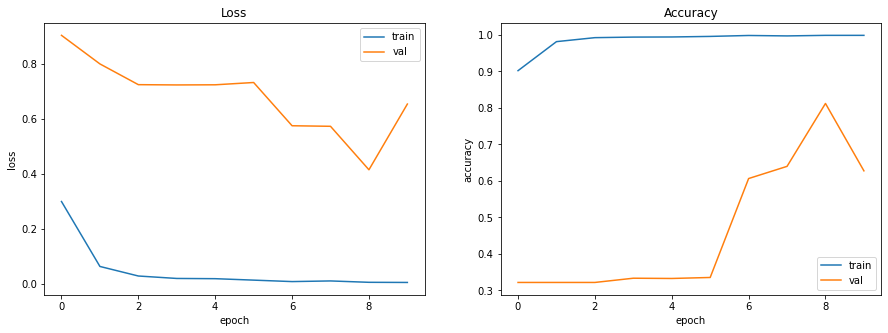

In [7]:
import matplotlib.pyplot as plt
history = history.history

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(history['loss'], label='train')
plt.plot(history['val_loss'], label='val')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title("Loss")

plt.subplot(1, 2, 2)
plt.plot(history['accuracy'], label='train')
plt.plot(history['val_accuracy'], label='val')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title("Accuracy")
plt.show()